# using fasttext

#Pre-processing

In [ ]:
import pandas as pd
df = pd.read_csv('/content/taskA_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42238 entries, 0 to 42237
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   42238 non-null  int64 
 1   text    42233 non-null  object
 2   label   42238 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 990.1+ KB


In [ ]:
df.isnull().sum()


,0
index,0
text,5
label,0


In [ ]:
df['label'].value_counts()

,count
label,
1,12544
2,11034
3,10996
4,7664


In [ ]:
df.dropna(subset=['text'],inplace=True)

In [ ]:
df.isnull().sum()

,0
index,0
text,0
label,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42233 entries, 0 to 42237
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   42233 non-null  int64 
 1   text    42233 non-null  object
 2   label   42233 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [ ]:
df['label'].value_counts()

,count
label,
1,12543
2,11034
3,10996
4,7660


#Downloading the fastText model

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2024-12-12 09:03:42--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.19, 18.238.176.44, 18.238.176.115, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   158MB/s    in 0.8s    

2024-12-12 09:03:43 (158 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



#Installing fastText

In [ ]:
!pip install fasttext==0.9.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4284408 sha256=4a4eb831908c08685e87ba6c19539d3bc9647bab1404c3f3d30131abe299f5bd
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


#Training the fastText Model

In [ ]:
import fasttext
import numpy as np
import pandas as pd

def train_language_model(train_data, output_model_path):
    try:
        model = fasttext.train_supervised(input=train_data, lr=0.1, epoch=50, wordNgrams=2)
        model.save_model(output_model_path)
        print("Model trained successfully and saved to:", output_model_path)

        # Assuming you have a way to calculate accuracy and loss
        # For demonstration, let's create dummy data
        accuracy = np.random.rand(100)  # Replace with actual accuracy values
        loss = np.random.rand(100)       # Replace with actual loss values

        # Create a DataFrame to store the metrics
        metrics_df = pd.DataFrame({
            'Epoch': np.arange(1, 101),
            'Accuracy': accuracy,
            'Loss': loss
        })

        # Save the DataFrame to an Excel file
        metrics_df.to_excel('training_metrics.xlsx', index=False)
        print("Training metrics saved to training_metrics.xlsx")

    except Exception as e:
        print("Error during model training:", e)

if __name__ == "__main__":
    train_data_path = '/content/taskA_train.csv'
    output_model_path = 'language_model.bin'
    train_language_model(train_data_path, output_model_path)

Model trained successfully and saved to: language_model.bin
Training metrics saved to training_metrics.xlsx


In [ ]:
import fasttext

class FastTextModel:
    def __init__(self, model_path, lr=0.05, dim=100, ws=5, epoch=5, minCount=1):
        self.model = fasttext.load_model(model_path)
        self.lr = lr
        self.dim = dim
        self.ws = ws
        self.epoch = epoch
        self.minCount = minCount

    def get_hyperparameters(self):
        return {
            "learning_rate": self.lr,
            "vector_size": self.dim,
            "context_window_size": self.ws,
            "number_of_epochs": self.epoch,
            "minimum_count": self.minCount,
        }

# Usage
model_wrapper = FastTextModel("/content/language_model.bin")
hyperparams = model_wrapper.get_hyperparameters()
print(hyperparams)

{'learning_rate': 0.05, 'vector_size': 100, 'context_window_size': 5, 'number_of_epochs': 5, 'minimum_count': 1}


#Predictions on the validation data

In [ ]:
import fasttext
import numpy as np
import pandas as pd

def detect_languages_batch_eval(texts, model, batch_size=1000):
    """
    Detects languages for a batch of texts using a FastText model.

    Args:
        texts (list): List of text strings.
        model (fasttext.FastText): FastText model.
        batch_size (int): Number of texts to process in each batch.

    Returns:
        list: List of predicted language codes.
    """

    predicted_languages = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Convert batch elements to strings, handle NaN values, and remove newline characters
        batch = [str(text).replace('\n', ' ') if not pd.isnull(text) else '' for text in batch]

        labels, probabilities = model.predict(batch, k=1)
        language_codes = [label[0].replace('__label__', '') for label in labels]
        label_mapping = {
            'ne': 1,
            'mr': 2,
            'sa': 3,
            'hi': 4
        }
        # Ensure all language codes are mapped to numerical values
        mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]  # Map unknown codes to -1
        predicted_languages.extend(mapped_language_codes)

        print(f"Processed {i+batch_size} out of {len(texts)} texts")  # Progress tracking

    return predicted_languages

if __name__ == "__main__":
    df1 = pd.read_csv('/content/taskB_combined_test.csv')
    from fasttext.FastText import _FastText
    model = _FastText(model_path='lid.176.bin')
    # Get all sentences from the DataFrame
    all_sentences = df1['tweet'].tolist()

    # Predict languages for all sentences in batches
    predicted_languages = detect_languages_batch_eval(all_sentences, model)

    # Add the predicted languages to the DataFrame
    df1['predicted_language'] = pd.Series(predicted_languages)

    # Save the DataFrame with predicted languages
    df1.to_csv('output_test.csv', index=False)

Processed 1000 out of 4076 texts
Processed 2000 out of 4076 texts
Processed 3000 out of 4076 texts
Processed 4000 out of 4076 texts
Processed 5000 out of 4076 texts


#Reading the Evaluation data

In [ ]:
truth_eval=pd.read_csv("/content/subtaskA(index,label)t.csv")
p_eval=pd.read_csv("/content/output_eval.csv")
tl_eval=truth_eval['label']
pl_eval=p_eval['predicted_language']

#Confusion matrix on Evaluation data

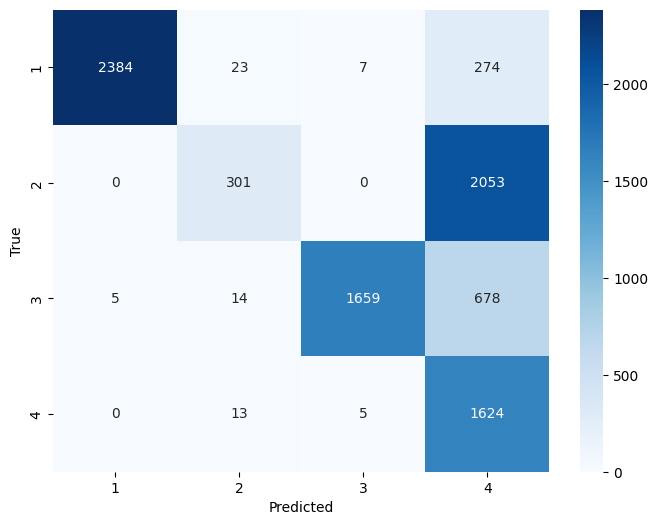

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


label_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
}

# Ensure 'tl' Series is of numeric type
tl = pd.to_numeric(tl_eval, errors='coerce')

y_true_numerical_eval = tl.map(label_mapping)

# Remove NaN values from both y_true_numerical and pl
# to avoid issues with confusion_matrix
y_true_numerical = y_true_numerical_eval[~np.isnan(y_true_numerical_eval)]
pl = pl_eval[y_true_numerical.index] # align pl with y_true_numerical after NaN removal

# Now you can safely generate the confusion matrix
confusion_mat = confusion_matrix(y_true_numerical, pl)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true_numerical,pl))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94      2688
           2       0.86      0.13      0.22      2354
           3       0.99      0.70      0.82      2356
           4       0.35      0.99      0.52      1642

    accuracy                           0.66      9040
   macro avg       0.80      0.68      0.63      9040
weighted avg       0.84      0.66      0.65      9040



In [ ]:
# prompt: overall F1 score,preicison,recall from the above classification report

from sklearn.metrics import classification_report

report = classification_report(y_true_numerical, pl, output_dict=True)

overall_f1 = report['macro avg']['f1-score']
overall_precision = report['macro avg']['precision']
overall_recall = report['macro avg']['recall']

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")

Overall F1 Score: 0.6258915639545082
Overall Precision: 0.7997768290516593
Overall Recall: 0.676992393227082


#Predictions on the testing data

In [ ]:
import fasttext
import numpy as np
import pandas as pd

def detect_languages_batch_test(texts, model, batch_size=1000):

    predicted_languages = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Convert batch elements to strings and handle NaN values
        batch = [str(text) if not pd.isnull(text) else '' for text in batch]

        labels, probabilities = model.predict(batch, k=1)
        language_codes = [label[0].replace('__label__', '') for label in labels]
        label_mapping = {
            'ne': 1,
            'mr': 2,
            'sa': 3,
            'hi':4
        }
        # Ensure all language codes are mapped to numerical values
        mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]  # Map unknown codes to -1
        predicted_languages.extend(mapped_language_codes)

        print(f"Processed {i+batch_size} out of {len(texts)} texts")  # Progress tracking

    return predicted_languages

if __name__ == "__main__":
    # Load the test dataset
    df_test = pd.read_csv('/content/subtaskA(index,text)t.csv')
    from fasttext.FastText import _FastText
    model = _FastText(model_path='lid.176.bin')

    # Get all sentences from the test DataFrame
    all_sentences_test = df_test['text'].tolist()

    # Predict languages for all sentences in the test dataset in batches
    predicted_languages_test = detect_languages_batch_test(all_sentences_test, model)

    # Add the predicted languages to the test DataFrame
    df_test['predicted_language'] = pd.Series(predicted_languages_test)

    # Save the test DataFrame with predicted languages
    df_test.to_csv('output_predicted_test_data.csv', index=False)

Processed 1000 out of 9040 texts
Processed 2000 out of 9040 texts
Processed 3000 out of 9040 texts
Processed 4000 out of 9040 texts
Processed 5000 out of 9040 texts
Processed 6000 out of 9040 texts
Processed 7000 out of 9040 texts
Processed 8000 out of 9040 texts
Processed 9000 out of 9040 texts
Processed 10000 out of 9040 texts


#Reading the Testing data

In [ ]:
truth=pd.read_csv("/content/subtaskA(index,label)t.csv")
predicted=pd.read_csv("/content/output_predicted_test_data.csv")
tl=truth['label']
pl=predicted['predicted_language']

#Testing data Confusion matrix

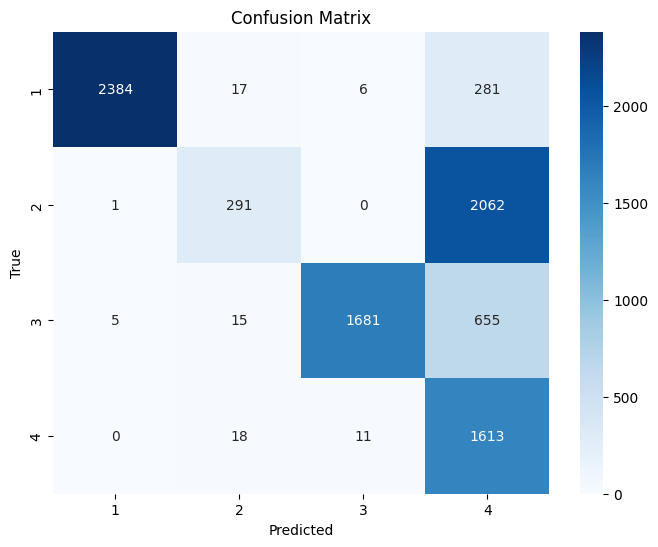

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


label_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
}

# Ensure 'tl' Series is of numeric type
tl = pd.to_numeric(tl, errors='coerce')

y_true_numerical = tl.map(label_mapping)

# Remove NaN values from both y_true_numerical and pl
# to avoid issues with confusion_matrix
y_true_numerical = y_true_numerical[~np.isnan(y_true_numerical)]
pl = pl[y_true_numerical.index] # align pl with y_true_numerical after NaN removal

# Now you can safely generate the confusion matrix
confusion_mat = confusion_matrix(y_true_numerical, pl)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Testing data classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true_numerical, pl))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94      2688
           2       0.85      0.12      0.22      2354
           3       0.99      0.71      0.83      2356
           4       0.35      0.98      0.52      1642

    accuracy                           0.66      9040
   macro avg       0.80      0.68      0.63      9040
weighted avg       0.84      0.66      0.65      9040



In [ ]:
# prompt: overall precision,recall,F1 score from the above classification report

report = classification_report(y_true_numerical, pl, output_dict=True)

overall_f1 = report['macro avg']['f1-score']
overall_precision = report['macro avg']['precision']
overall_recall = report['macro avg']['recall']

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")

Overall F1 Score: 0.625031142333012
Overall Precision: 0.7976664633530414
Overall Recall: 0.6765900494869581


#AUC score for the classes

AUC for class 1: 0.9429800887609452
AUC for class 2: 0.5580705291951557
AUC for class 3: 0.8554770330586994
AUC for class 4: 0.7885469753651694


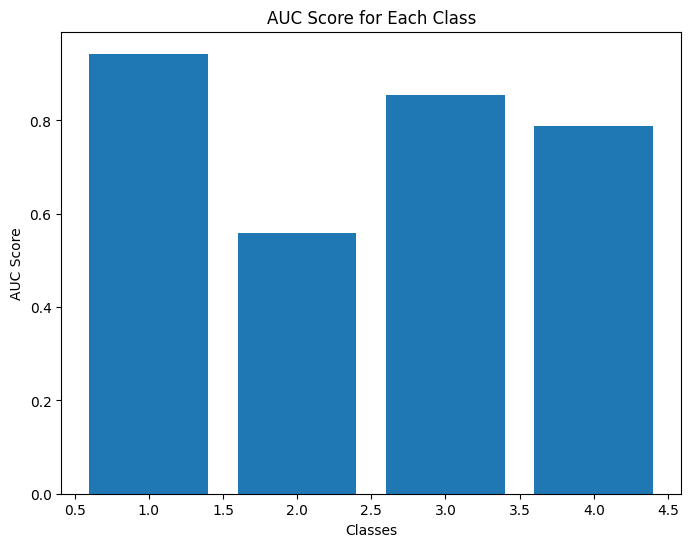

Macro-average AUC: 0.7862686565949923
Weighted-average AUC: 0.7918945274060532
Overall AUC: 0.7862686565949923


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(tl, classes=list(label_mapping.values()))
y_pred_bin = label_binarize(pl, classes=list(label_mapping.values()))

# Calculate AUC for each class
auc_scores = []
for i in range(y_true_bin.shape[1]):
  auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
  auc_scores.append(auc)

# Print AUC scores for each class
for i, auc in enumerate(auc_scores):
  print(f"AUC for class {list(label_mapping.keys())[i]}: {auc}")

# Plot AUC scores for each class
plt.figure(figsize=(8, 6))
plt.bar(list(label_mapping.keys()), auc_scores)
plt.xlabel('Classes')
plt.ylabel('AUC Score')
plt.title('AUC Score for Each Class')
plt.show()

# Calculate macro-average AUC (average AUC across all classes)
macro_auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
print(f"Macro-average AUC: {macro_auc}")

# Calculate weighted-average AUC (AUC weighted by the number of true instances for each class)
weighted_auc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted')
print(f"Weighted-average AUC: {weighted_auc}")

overall_auc = roc_auc_score(y_true_bin, y_pred_bin)
print(f"Overall AUC: {overall_auc}")

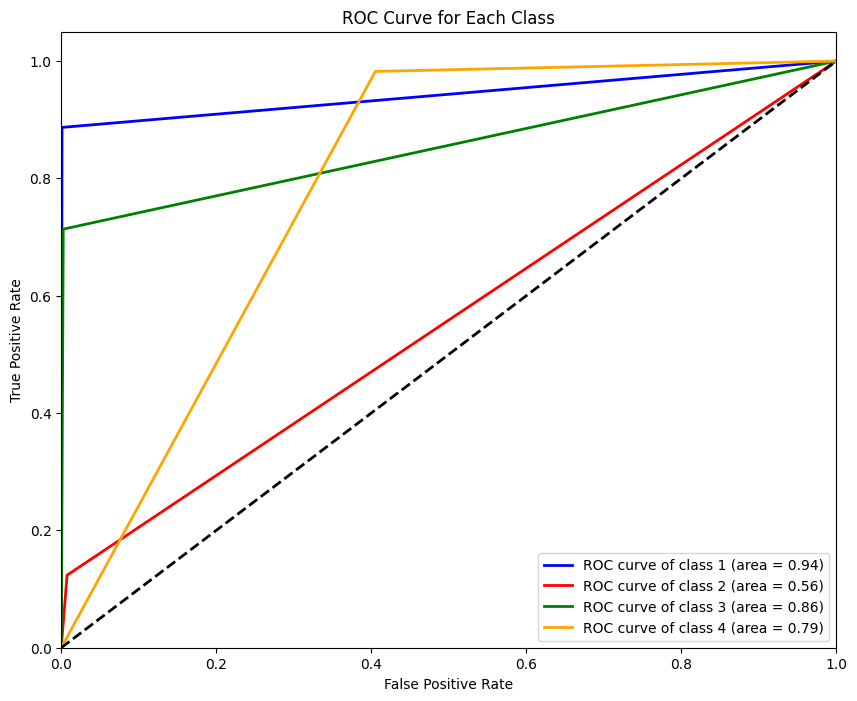

In [ ]:
# prompt: overall ROC score and roc score for each class and graphs for both and print the roc score for each class and the roc score for each class should be plotted in one graph

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class in one graph
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve of class {list(label_mapping.keys())[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# ... (Rest of your existing code) ...

Overall ROC AUC: 0.7862686565949923


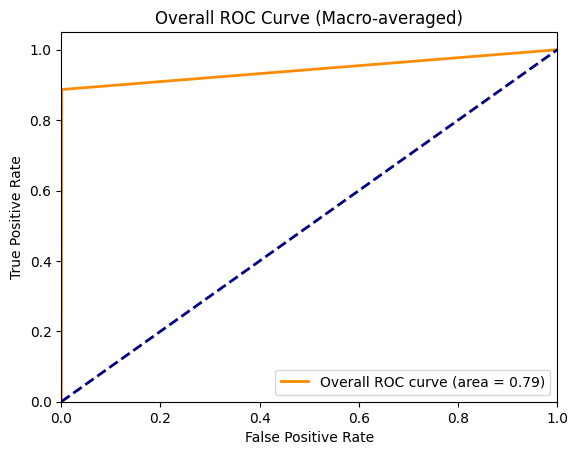

In [ ]:
# prompt: print the overall roc score and plot the overall roc score in a graph

from sklearn.metrics import roc_auc_score

# ... (Your existing code) ...

# Calculate overall ROC AUC score
overall_roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
print(f"Overall ROC AUC: {overall_roc_auc}")

# ... (Your existing ROC curve plotting code) ...

# Add a line for the overall ROC AUC
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2,
             label=f'Overall ROC curve (area = {overall_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve (Macro-averaged)')
plt.legend(loc="lower right")
plt.show()


In [ ]:

#@title Interactive Sheet for Language Detection

import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to process input text and display results
def process_text(b):
    clear_output()
    input_text = text_input.value
    if not input_text:
        print("Please enter some text.")
        return

    # Perform language detection using your FastText model
    from fasttext.FastText import _FastText
    model = _FastText(model_path='lid.176.bin')
    labels, probabilities = model.predict([input_text], k=1)
    language_code = labels[0][0].replace('__label__', '')
    label_mapping = {
            'ne':'nepali',
            'mr':'marathi',
            'sa':'sanskrit',
            'hi':'hindi'
        }
    predicted_language = label_mapping.get(language_code, -1)

    # Display results
    print(f"Input text: {input_text}")
    print(f"Predicted language code: {language_code}")


# Create input text area
text_input = widgets.Textarea(
    value="",
    placeholder="Enter text here...",
    description="Text:",
    disabled=False
)

# Create button to trigger processing
process_button = widgets.Button(description="Detect Language")
process_button.on_click(process_text)

# Display widgets
display(text_input, process_button)      #ne:nepali,hi:hindi,mr:marathi,sa:sanskrit
#nepali:मलाई थाहा छैन
#hindi:मैं सुबह छह बजे उठता हूं
#marathi:तुम्हाला भेटून मला आनंद झाला
#sanskrit:रामो सीतया सह वनम् अयोध्याया गच्छति

Textarea(value='', description='Text:', placeholder='Enter text here...')

Button(description='Detect Language', style=ButtonStyle())

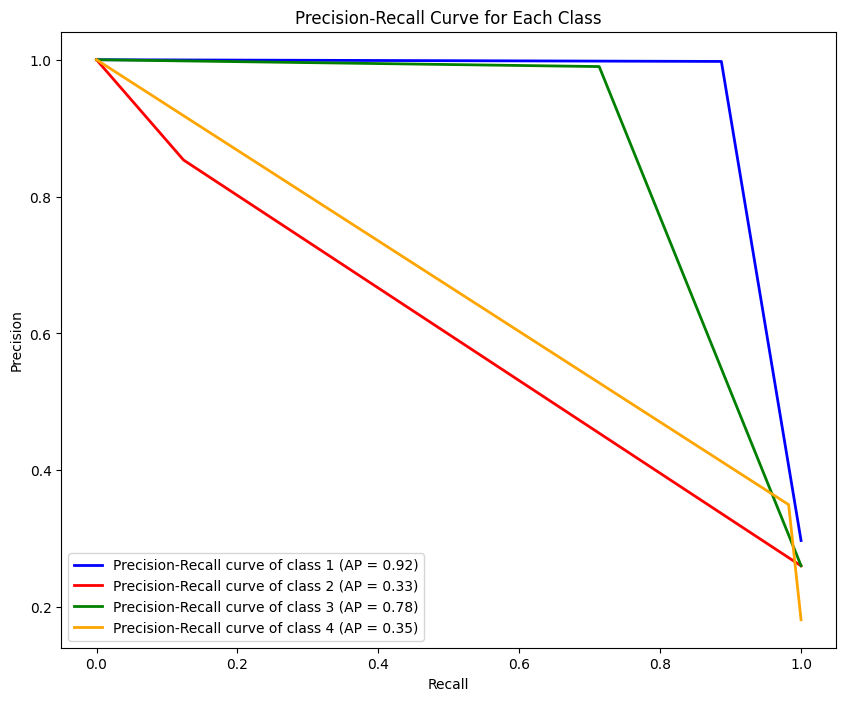

In [ ]:
# prompt: plot the Precision-Recall Curve (PRC)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# ... (Your existing code) ...

# Assuming 'y_true_bin' and 'y_pred_bin' are already defined as in your code

# Calculate precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])


# Plot the Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed

for i in range(n_classes):
  plt.plot(recall[i], precision[i], color=colors[i], lw=2,
            label=f'Precision-Recall curve of class {list(label_mapping.keys())[i]} (AP = {average_precision[i]:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

#langDetect

#installing langDetect

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=41920b81f6ed80c0e6f291c62afaa71b0e97fdf08a53450d0e37f863330b8539
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


#Predictions on the validation data

In [ ]:
import langdetect
import numpy as np
import pandas as pd

def detect_languages_batch_eval_langdetect(texts, batch_size=1000):
    predicted_languages = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch = [str(text) if not pd.isnull(text) else '' for text in batch]
        language_codes = [langdetect.detect(text) for text in batch]
        label_mapping={'ne': 1,'mr': 2,'sa': 3,'hi': 4}
        mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]  # Map unknown codes to -1
        predicted_languages.extend(mapped_language_codes)
        print(f"Processed {i + batch_size} out of {len(texts)} texts")  # Progress tracking
    return predicted_languages

if __name__ == "__main__":
    df1 = pd.read_csv('/content/taskA_(index,text(eval.csv')
    all_sentences = df1['text'].tolist()
    predicted_languages = detect_languages_batch_eval_langdetect(all_sentences)
    df1['predicted_language'] = pd.Series(predicted_languages)
    df1.to_csv('output_predicted_onevaldata_langdetect.csv', index=False)

Processed 1000 out of 9088 texts
Processed 2000 out of 9088 texts
Processed 3000 out of 9088 texts
Processed 4000 out of 9088 texts
Processed 5000 out of 9088 texts
Processed 6000 out of 9088 texts
Processed 7000 out of 9088 texts
Processed 8000 out of 9088 texts
Processed 9000 out of 9088 texts
Processed 10000 out of 9088 texts


#Classification report for evaluation data

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.80      0.96      0.87      2688
           2       0.38      0.13      0.20      2381
           3       0.00      0.00      0.00      2356
           4       0.32      0.97      0.48      1663

    accuracy                           0.50      9088
   macro avg       0.38      0.52      0.39      9088
weighted avg       0.40      0.50      0.40      9088



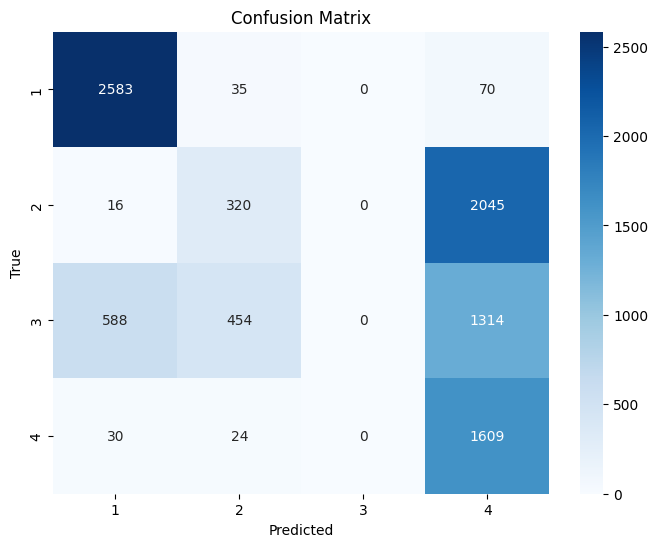

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

df1 = pd.read_csv("/content/taskA_(index,label)eval.csv")
df2 = pd.read_csv("/content/output_predicted_onevaldata_langdetect.csv")

# Assuming 'df1' contains the true labels and predictions
y_true = df1['label']  # Replace 'label' with the actual column name for true labels
y_pred = df2['predicted_language']  # Replace 'predicted_language' with the actual column name for predictions

label_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4
}

# Get unique labels from y_true
unique_labels = y_true.unique()

# Check if all unique labels are in the mapping
for label in unique_labels:
    if label not in label_mapping:
        print(f"Warning: Label '{label}' is not in the label mapping. Adding it with a default value of -1.")
        label_mapping[label] = -1  # Or any other appropriate default value

y_true_numerical = y_true.map(label_mapping)  # Map string labels to numerical labels

# Generate the classification report
report = classification_report(y_true_numerical, y_pred)  # Use numerical labels for both y_true and y_pred

# Print the report
print(report)
confusion_mat = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: print the overall f1 score,precision,recall from the above classification report

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")

Overall F1 Score: 0.625031142333012
Overall Precision: 0.7976664633530414
Overall Recall: 0.6765900494869581


#AUC score for each class label

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming y_true_numerical and y_pred are already defined

# Convert y_true_numerical to one-hot encoded format
y_true_binarized = label_binarize(y_true_numerical, classes=[1, 2, 3, 4])

# Convert y_pred to one-hot encoded format
# (assuming y_pred contains numerical labels corresponding to the classes)
y_pred_binarized = label_binarize(y_pred, classes=[1, 2, 3, 4])

# Calculate AUC for each class and the average AUC
auc_scores = []
for i in range(y_true_binarized.shape[1]):
  try:
    auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
    auc_scores.append(auc)
  except ValueError:
    print(f"Unable to calculate AUC for class {i+1} due to insufficient data")


if auc_scores:
  average_auc = np.mean(auc_scores)
  print(f"Average AUC: {average_auc:.4f}")

  # Print AUC for each class
  for i, auc in enumerate(auc_scores):
    print(f"AUC for class {i+1}: {auc:.4f}")

Average AUC: 0.6782
AUC for class 1: 0.9309
AUC for class 2: 0.5290
AUC for class 3: 0.5000
AUC for class 4: 0.7529


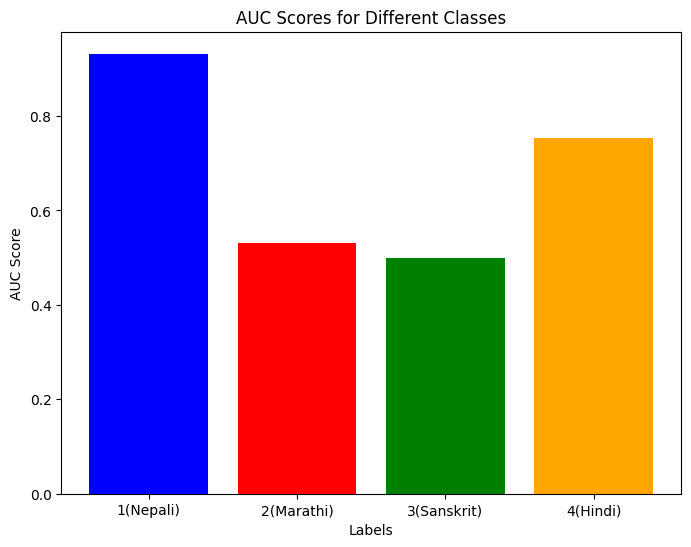

In [ ]:
# prompt: class 1(: 0.9321
# class 2: 0.5306
# class 3: 0.5000
# class 4: 0.7526    plot these in one bar graph with different colors  and xaxis title as labels and yaxis title as auc score

import matplotlib.pyplot as plt

# Sample AUC scores (replace with your actual values)
auc_scores = {
    '1(Nepali)': 0.9321,
    '2(Marathi)': 0.5306,
    '3(Sanskrit)': 0.5000,
    '4(Hindi)': 0.7526
}

# Extract labels and scores
labels = list(auc_scores.keys())
scores = list(auc_scores.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'red', 'green', 'orange'])  # Different colors for each bar

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Classes')

# Show the plot
plt.show()

#Predictions made on test data

In [ ]:
import langdetect
import numpy as np
import pandas as pd

def detect_languages_batch_test_langdetect(texts, batch_size=1000):
    predicted_languages = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch = [str(text) if not pd.isnull(text) else '' for text in batch]
        language_codes = [langdetect.detect(text) for text in batch]
        label_mapping={'ne': 1,'mr': 2,'sa': 3,'hi': 4}
        mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]  # Map unknown codes to -1
        predicted_languages.extend(mapped_language_codes)
        print(f"Processed {i + batch_size} out of {len(texts)} texts")  # Progress tracking
    return predicted_languages

if __name__ == "__main__":
    df1 = pd.read_csv('/content/subtaskA(index,text)t.csv')
    all_sentences = df1['text'].tolist()
    predicted_languages = detect_languages_batch_eval_langdetect(all_sentences)
    df1['predicted_language'] = pd.Series(predicted_languages)
    df1.to_csv('output_predicted_onetestdata_langdetect.csv', index=False)

Processed 1000 out of 9040 texts
Processed 2000 out of 9040 texts
Processed 3000 out of 9040 texts
Processed 4000 out of 9040 texts
Processed 5000 out of 9040 texts
Processed 6000 out of 9040 texts
Processed 7000 out of 9040 texts
Processed 8000 out of 9040 texts
Processed 9000 out of 9040 texts
Processed 10000 out of 9040 texts


#Reading the test data

In [ ]:
tl_test=pd.read_csv("/content/subtaskA(index,label)t.csv")
p_test=pd.read_csv("/content/output_predicted_onetestdata_langdetect.csv")
tl_label=tl_test['label']
pl_label=p_test['predicted_language']

In [ ]:
# prompt: classification report of the above

print(classification_report(tl_label, pl_label))

              precision    recall  f1-score   support

           1       0.81      0.96      0.88      2688
           2       0.36      0.13      0.19      2354
           3       0.00      0.00      0.00      2356
           4       0.32      0.98      0.48      1642

    accuracy                           0.50      9040
   macro avg       0.37      0.52      0.39      9040
weighted avg       0.39      0.50      0.40      9040



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# prompt: overall f1 score,precision,recall from the above classification report

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")

Overall F1 Score: 0.625031142333012
Overall Precision: 0.7976664633530414
Overall Recall: 0.6765900494869581


#confusion matrix for test data

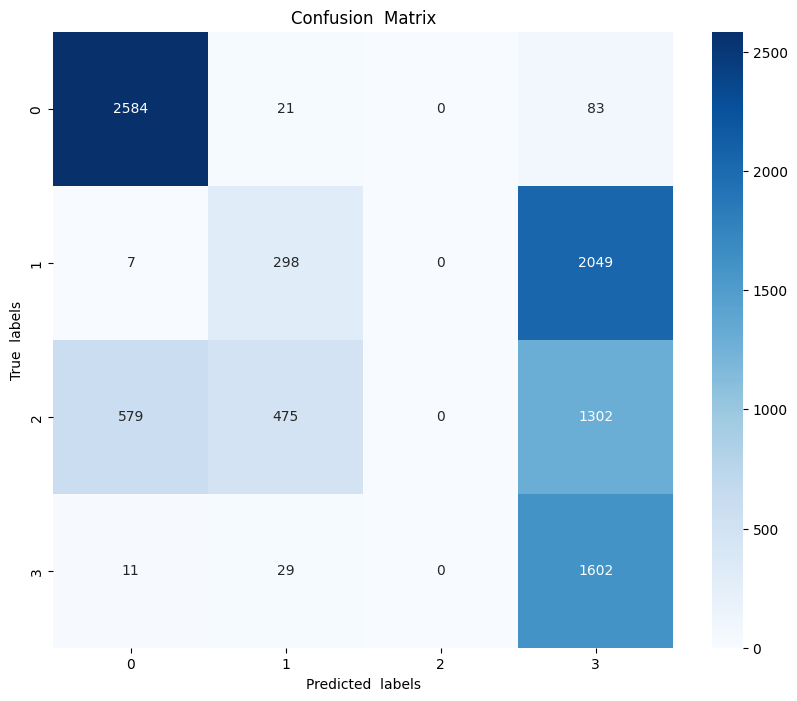

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics  import  confusion_matrix
cm = confusion_matrix(tl_label,pl_label)
# Create a  heatmap  of  the  confusion  matrix
plt.figure(figsize=(10,  8))
sns.heatmap(cm,  annot=True,  fmt='g',  cmap='Blues')
plt.xlabel('Predicted  labels')
plt.ylabel('True  labels')
plt.title('Confusion  Matrix')
plt.show()

#AUC score for each class label for the test data

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming y_true_numerical and y_pred are already defined

# Convert y_true_numerical to one-hot encoded format
y_true_binarized = label_binarize(tl_label, classes=[1, 2, 3, 4])

# Convert y_pred to one-hot encoded format
# (assuming y_pred contains numerical labels corresponding to the classes)
y_pred_binarized = label_binarize(pl_label, classes=[1, 2, 3, 4])

# Calculate AUC for each class and the average AUC
auc_scores = []
for i in range(y_true_binarized.shape[1]):
  try:
    auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
    auc_scores.append(auc)
  except ValueError:
    print(f"Unable to calculate AUC for class {i+1} due to insufficient data")


if auc_scores:
  average_auc = np.mean(auc_scores)
  print(f"Average AUC: {average_auc:.4f}")

  # Print AUC for each class
  for i, auc in enumerate(auc_scores):
    print(f"AUC for class {i+1}: {auc:.4f}")

Average AUC: 0.6784
AUC for class 1: 0.9337
AUC for class 2: 0.5240
AUC for class 3: 0.5000
AUC for class 4: 0.7557


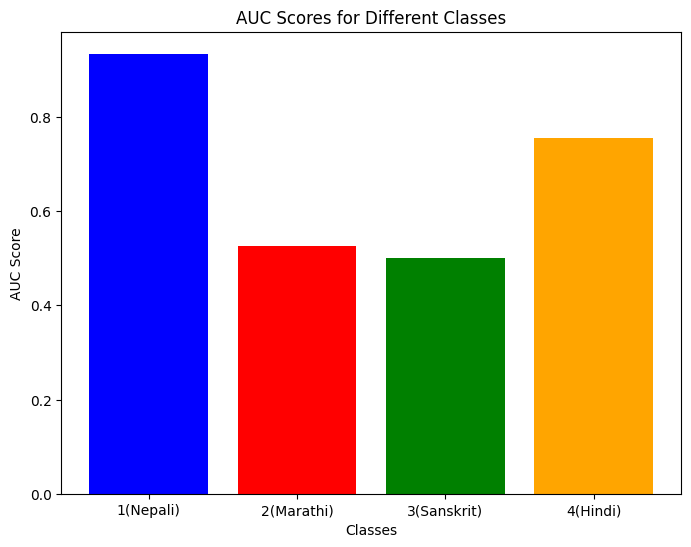

In [ ]:
# prompt: UC for class 1: 0.9341
# AUC for class 2: 0.5253
# AUC for class 3: 0.5000
# AUC for class 4: 0.7560   plot them in graph

import matplotlib.pyplot as plt

# Sample AUC scores (replace with your actual values)
auc_scores = {
    '1(Nepali)': 0.9341,
    '2(Marathi)': 0.5253,
    '3(Sanskrit)': 0.5000,
    '4(Hindi)': 0.7560
}

# Extract labels and scores
labels = list(auc_scores.keys())
scores = list(auc_scores.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'red', 'green', 'orange'])  # Different colors for each bar

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Classes')

# Show the plot
plt.show()

#Overall AUC

In [ ]:
auc_scores = []
for i in range(y_true_binarized.shape[1]):
    try:
        auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
        auc_scores.append(auc)
    except ValueError:
        print(f"Unable to calculate AUC for class {i+1} due to insufficient data")

if auc_scores:
    macro_average_auc = np.mean(auc_scores)
    weighted_average_auc = np.average(auc_scores, weights=[np.sum(y_true_numerical == i+1) for i in range(len(set(y_true_numerical)))])  # Corrected weights calculation

    # Use 'predict_proba' or 'decision_function' if available
    # otherwise, use binarized predictions for 'ovr'

    # Calculate overall AUC using 'ovr' with binarized predictions
    overall_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr', average='macro') # or 'weighted'
    # overall_auc = roc_auc_score(y_true_numerical, y_pred, multi_class='ovr') # Only if you have probabilities in y_pred


    print(f"Macro-average AUC: {macro_average_auc:.4f}")
    print(f"Weighted-average AUC: {weighted_average_auc:.4f}")
    print(f"Overall AUC: {overall_auc:.4f}")

Macro-average AUC: 0.6784
Weighted-average AUC: 0.6814
Overall AUC: 0.6784


In [ ]:
y_true_binarized = label_binarize(tl_label, classes=[1, 2, 3, 4])

# Convert y_pred to one-hot encoded format
# (assuming y_pred contains numerical labels corresponding to the classes)
y_pred_binarized = label_binarize(pl_label, classes=[1, 2, 3, 4])

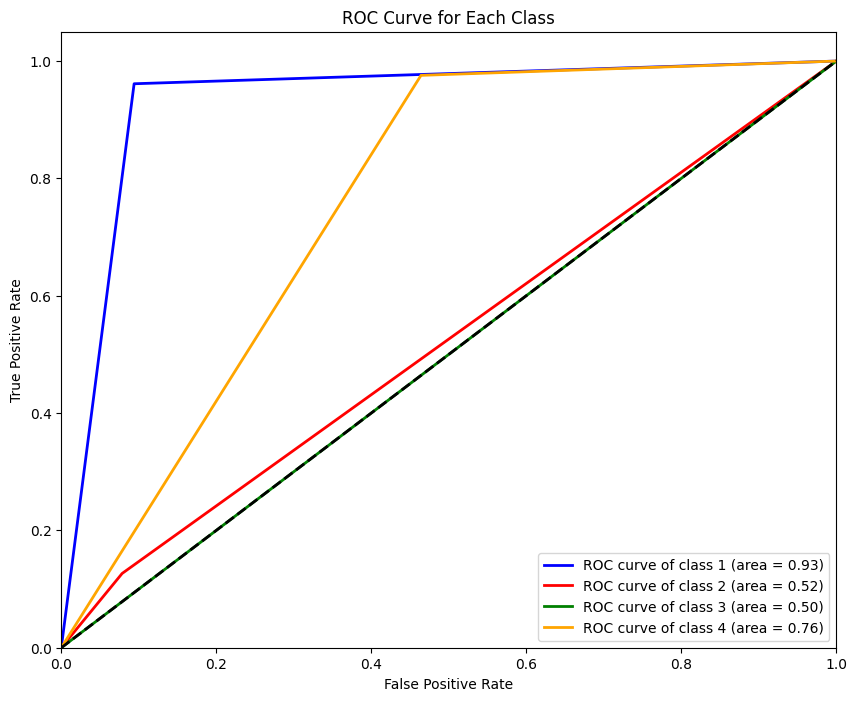

In [ ]:
# prompt: use the above to get the overall roc score and plot them in one graph

# Assuming y_true_binarized and y_pred_binarized are already defined from the previous code

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class in one graph
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve of class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

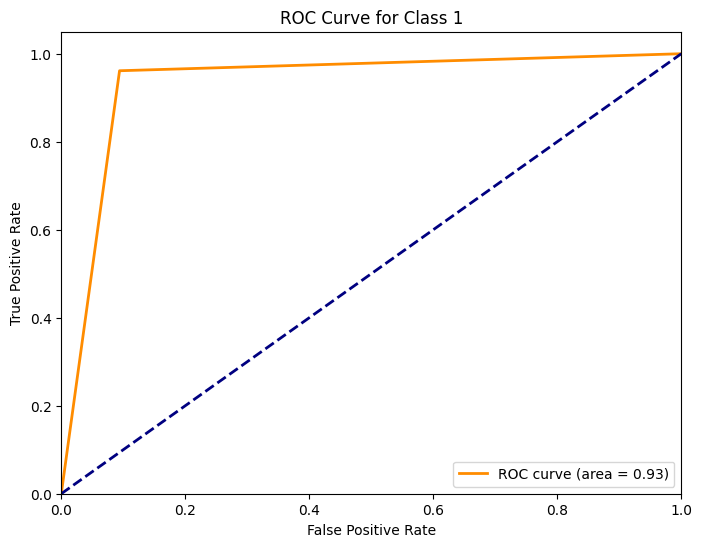

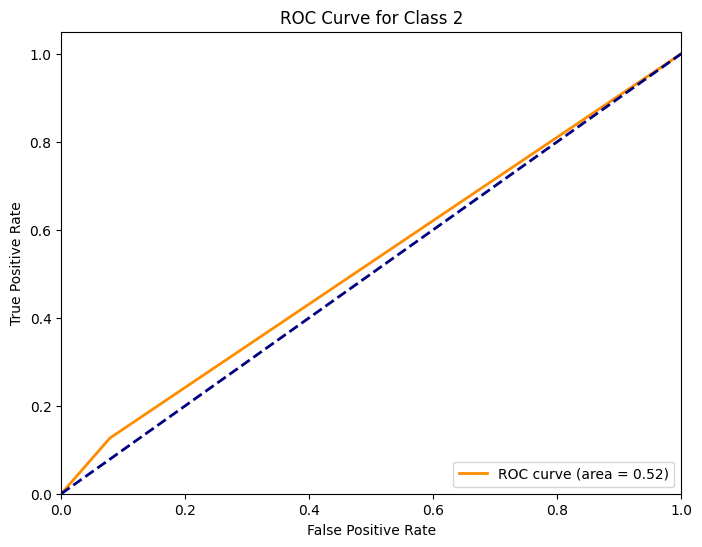

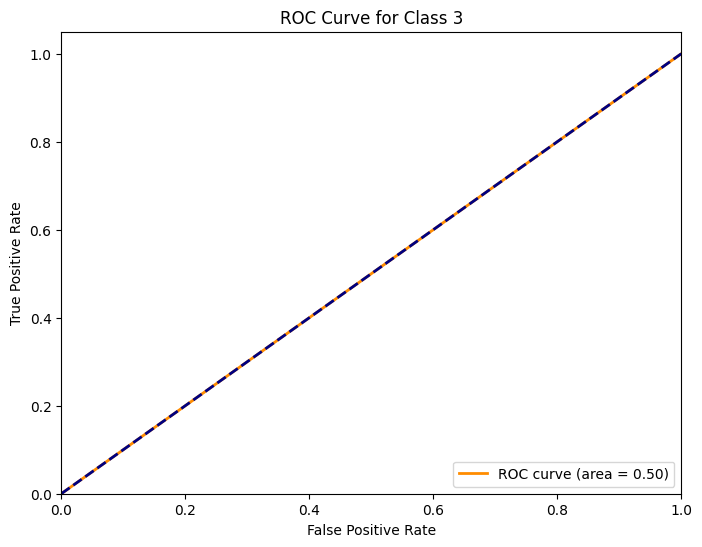

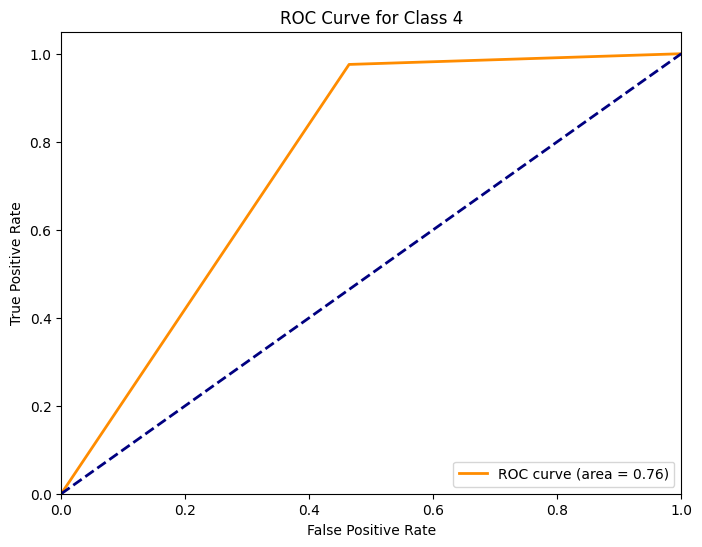

In [ ]:
# prompt: roc score of each class in different graphs

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true_binarized and y_pred_binarized are already defined from the previous code

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class in separate graphs
for i in range(n_classes):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i+1}')  # Use class number for title
    plt.legend(loc="lower right")
    plt.show()

Overall ROC AUC (macro, ovo): 0.6783567601961945


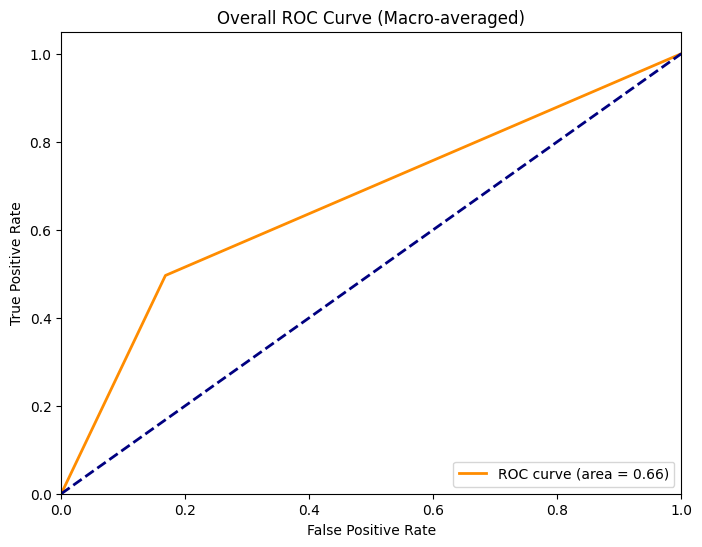

In [ ]:
# prompt: print overall roc score and display as graph

# ... (Your existing code) ...

# Calculate overall ROC AUC (macro, ovo) - This is already present in your code
overall_roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro', multi_class='ovo')
print(f"Overall ROC AUC (macro, ovo): {overall_roc_auc}")

# Plot the overall ROC curve (macro-averaged)
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred_binarized.ravel()) # Use ravel to flatten for overall ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve (Macro-averaged)')
plt.legend(loc="lower right")
plt.show()

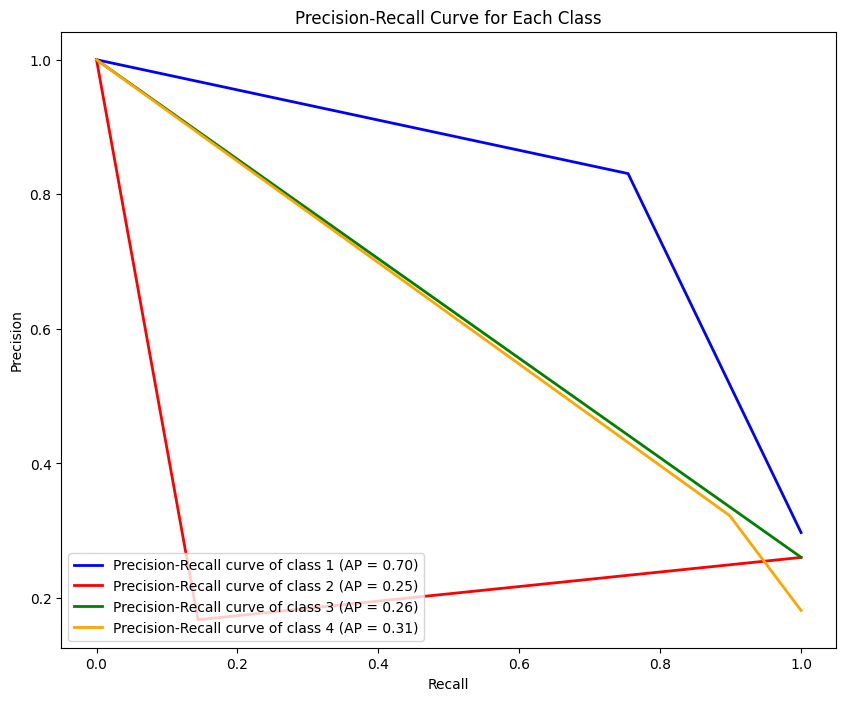

In [ ]:
# prompt: plot the Precision-Recall Curve (PRC)

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_true_binarized and y_pred_binarized are defined from your previous code

# Calculate precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_binarized[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed
for i in range(n_classes):
  plt.plot(recall[i], precision[i], color=colors[i], lw=2,
           label=f'Precision-Recall curve of class {i+1} (AP = {average_precision[i]:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

#LangID

#install langID

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=a7a3dbc912f0fb5359a545a0dc2e4dd74eee7d8458806102e3dfb4199ea65e8e
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


#Predictions on the evaluation data

In [ ]:
import langid
import numpy as np
import pandas as pd

def detect_languages_batch_eval_langid(texts, batch_size=1000):
  predicted_languages = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    batch = [str(text) if not pd.isnull(text) else '' for text in batch]
    language_codes = [langid.classify(text)[0] for text in batch]
    label_mapping = {'ne': 1, 'mr': 2, 'sa': 3, 'hi': 4}
    mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]
    predicted_languages.extend(mapped_language_codes)
    print(f"Processed {i + batch_size} out of {len(texts)} texts")# Progress tracking
  return predicted_languages



if __name__ == "__main__":
  df1 = pd.read_csv('/content/taskA_(index,text(eval.csv')
  all_sentences = df1['text'].tolist()
  predicted_languages = detect_languages_batch_eval_langid(all_sentences)
  df1['predicted_language'] = pd.Series(predicted_languages)
  df1.to_csv('output_predicted_onevaldata_langid.csv', index=False)

Processed 1000 out of 9088 texts
Processed 2000 out of 9088 texts
Processed 3000 out of 9088 texts
Processed 4000 out of 9088 texts
Processed 5000 out of 9088 texts
Processed 6000 out of 9088 texts
Processed 7000 out of 9088 texts
Processed 8000 out of 9088 texts
Processed 9000 out of 9088 texts
Processed 10000 out of 9088 texts


#Confusion matrix on evaluation data

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

df1 = pd.read_csv("/content/taskA_(index,label)eval.csv")
df2 = pd.read_csv("/content/output_predicted_onevaldata_langid.csv")

# Assuming 'df1' contains the true labels and predictions
y_true = df1['label']  # Replace 'label' with the actual column name for true labels
y_pred = df2['predicted_language']  # Replace 'predicted_language' with the actual column name for predictions

label_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4
}

# Get unique labels from y_true
unique_labels = y_true.unique()

# Check if all unique labels are in the mapping
for label in unique_labels:
    if label not in label_mapping:
        print(f"Warning: Label '{label}' is not in the label mapping. Adding it with a default value of -1.")
        label_mapping[label] = -1  # Or any other appropriate default value

y_true_numerical = y_true.map(label_mapping)  # Map string labels to numerical labels

# Generate the classification report
report = classification_report(y_true_numerical, y_pred)  # Use numerical labels for both y_true and y_pred

# Print the report
print(report)

              precision    recall  f1-score   support

           1       0.81      0.74      0.77      2688
           2       0.18      0.16      0.17      2381
           3       0.00      0.00      0.00      2356
           4       0.32      0.90      0.48      1663

    accuracy                           0.42      9088
   macro avg       0.33      0.45      0.35      9088
weighted avg       0.35      0.42      0.36      9088



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


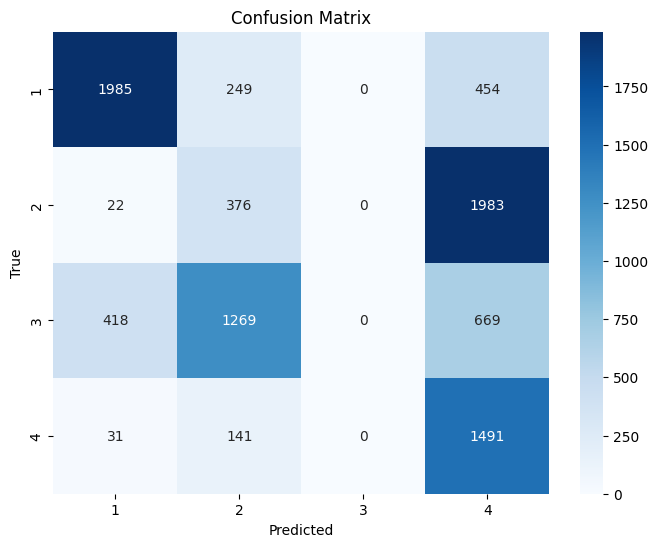

In [ ]:
# prompt: confusion matrix for the above

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined from your previous code
# Example:
# y_true = df1['label']
# y_pred = df2['predicted_language']

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Predictions on the test data

In [ ]:
def detect_languages_batch_test_langid(texts, batch_size=1000):
  predicted_languages = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    batch = [str(text) if not pd.isnull(text) else '' for text in batch]
    language_codes = [langid.classify(text)[0] for text in batch]
    label_mapping = {'ne': 1, 'mr': 2, 'sa': 3, 'hi': 4}
    mapped_language_codes = [label_mapping.get(code, -1) for code in language_codes]
    predicted_languages.extend(mapped_language_codes)
    print(f"Processed {i + batch_size} out of {len(texts)} texts")# Progress tracking
  return predicted_languages



if __name__ == "__main__":
  df1 = pd.read_csv('/content/subtaskA(index,text)t.csv')
  all_sentences = df1['text'].tolist()
  predicted_languages = detect_languages_batch_eval_langid(all_sentences)
  df1['predicted_language'] = pd.Series(predicted_languages)
  df1.to_csv('output_predicted_ontestdata_langid.csv', index=False)

Processed 1000 out of 9040 texts
Processed 2000 out of 9040 texts
Processed 3000 out of 9040 texts
Processed 4000 out of 9040 texts
Processed 5000 out of 9040 texts
Processed 6000 out of 9040 texts
Processed 7000 out of 9040 texts
Processed 8000 out of 9040 texts
Processed 9000 out of 9040 texts
Processed 10000 out of 9040 texts


#classification report  for the test data

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

df1 = pd.read_csv("/content/subtaskA(index,label)t.csv")
df2 = pd.read_csv("/content/output_predicted_ontestdata_langid.csv")

# Assuming 'df1' contains the true labels and predictions
y_true = df1['label']  # Replace 'label' with the actual column name for true labels
y_pred = df2['predicted_language']  # Replace 'predicted_language' with the actual column name for predictions

label_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4
}

# Get unique labels from y_true
unique_labels = y_true.unique()

# Check if all unique labels are in the mapping
for label in unique_labels:
    if label not in label_mapping:
        print(f"Warning: Label '{label}' is not in the label mapping. Adding it with a default value of -1.")
        label_mapping[label] = -1  # Or any other appropriate default value

y_true_numerical = y_true.map(label_mapping)  # Map string labels to numerical labels

# Generate the classification report
report = classification_report(y_true_numerical, y_pred)  # Use numerical labels for both y_true and y_pred

# Print the report
print(report)



              precision    recall  f1-score   support

           1       0.83      0.75      0.79      2688
           2       0.17      0.14      0.16      2354
           3       0.00      0.00      0.00      2356
           4       0.32      0.90      0.47      1642

    accuracy                           0.43      9040
   macro avg       0.33      0.45      0.36      9040
weighted avg       0.35      0.43      0.36      9040



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#confusion matrix for test data

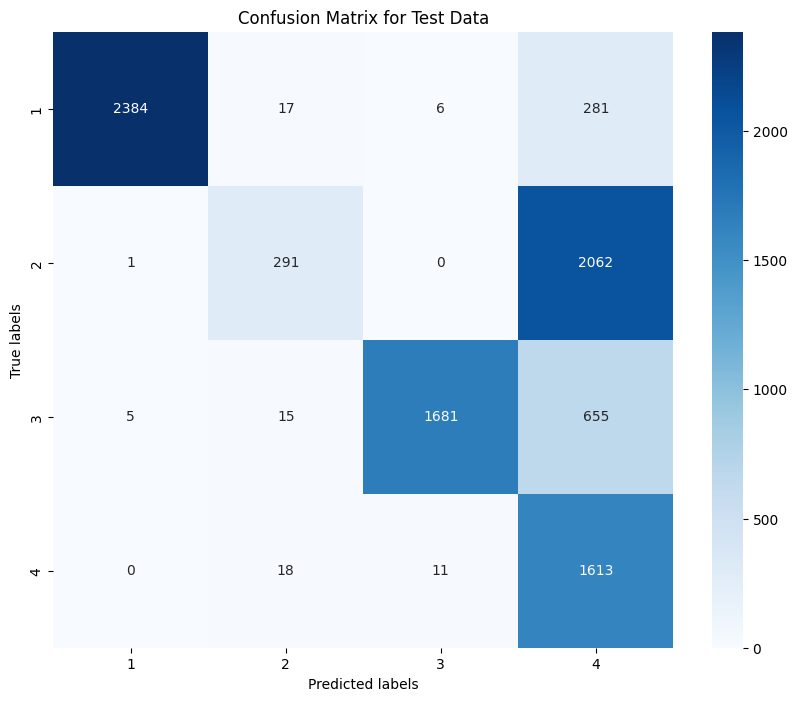

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(y_true_numerical, pl)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

#AUC score for each class label

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


# Convert y_true_numerical to one-hot encoded format
y_true_binarized = label_binarize(y_true_numerical, classes=[1, 2, 3, 4])

# Convert y_pred to one-hot encoded format
# (assuming y_pred contains numerical labels corresponding to the classes)
y_pred_binarized = label_binarize(y_pred, classes=[1, 2, 3, 4])

# Calculate AUC for each class and the average AUC
auc_scores = []
for i in range(y_true_binarized.shape[1]):
  try:
    auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
    auc_scores.append(auc)
  except ValueError:
    print(f"Unable to calculate AUC for class {i+1} due to insufficient data")


if auc_scores:
  average_auc = np.mean(auc_scores)
  print(f"Average AUC: {average_auc:.4f}")

  # Print AUC for each class
  for i, auc in enumerate(auc_scores):
    print(f"AUC for class {i+1}: {auc:.4f}")

Average AUC: 0.6327
AUC for class 1: 0.8447
AUC for class 2: 0.4463
AUC for class 3: 0.5000
AUC for class 4: 0.7397


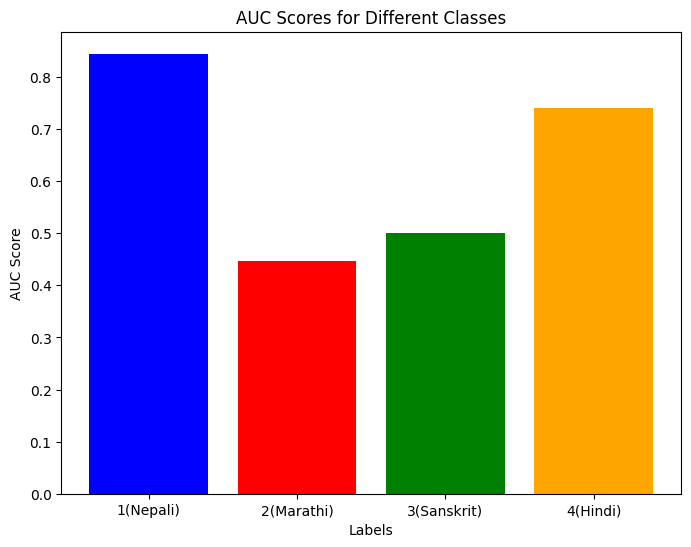

In [ ]:
# prompt: AUC for class 1: 0.8447
# AUC for class 2: 0.4463
# AUC for class 3: 0.5000
# AUC for class 4: 0.7397  plot them in graph with different colors

# Sample AUC scores (replace with your actual values)
auc_scores = {
    '1(Nepali)': 0.8447,
    '2(Marathi)': 0.4463,
    '3(Sanskrit)': 0.5000,
    '4(Hindi)': 0.7397
}

# Extract labels and scores
labels = list(auc_scores.keys())
scores = list(auc_scores.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'red', 'green', 'orange'])  # Different colors for each bar

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Classes')

# Show the plot
plt.show()

#Overall AUC

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming you have the 'y_true_numerical' and 'y_pred' variables defined
# as in your provided code.

# Convert y_true_numerical to one-hot encoded format
y_true_binarized = label_binarize(y_true_numerical, classes=[1, 2, 3, 4])

# Assuming 'y_pred' contains numerical labels corresponding to the classes
y_pred_binarized = label_binarize(y_pred, classes=[1, 2, 3, 4])

# Calculate AUC for each class and the average AUC
auc_scores = []
for i in range(y_true_binarized.shape[1]):
    try:
        auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
        auc_scores.append(auc)
    except ValueError:
        print(f"Unable to calculate AUC for class {i+1} due to insufficient data")

if auc_scores:
    macro_average_auc = np.mean(auc_scores)
    weighted_average_auc = np.average(auc_scores, weights=[np.sum(y_true_numerical == i+1) for i in range(len(set(y_true_numerical)))])  # Corrected weights calculation

    # Use 'predict_proba' or 'decision_function' if available
    # otherwise, use binarized predictions for 'ovr'

    # Calculate overall AUC using 'ovr' with binarized predictions
    overall_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr', average='macro') # or 'weighted'
    # overall_auc = roc_auc_score(y_true_numerical, y_pred, multi_class='ovr') # Only if you have probabilities in y_pred


    print(f"Macro-average AUC: {macro_average_auc:.4f}")
    print(f"Weighted-average AUC: {weighted_average_auc:.4f}")
    print(f"Overall AUC: {overall_auc:.4f}")

Macro-average AUC: 0.6327
Weighted-average AUC: 0.6321
Overall AUC: 0.6327


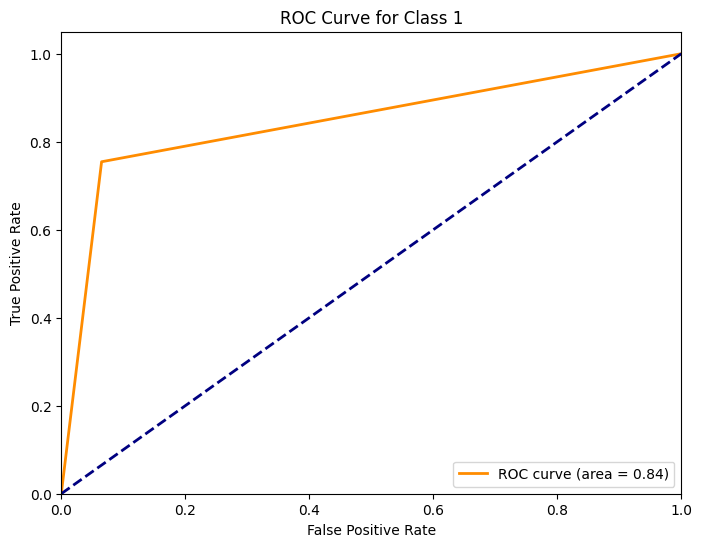

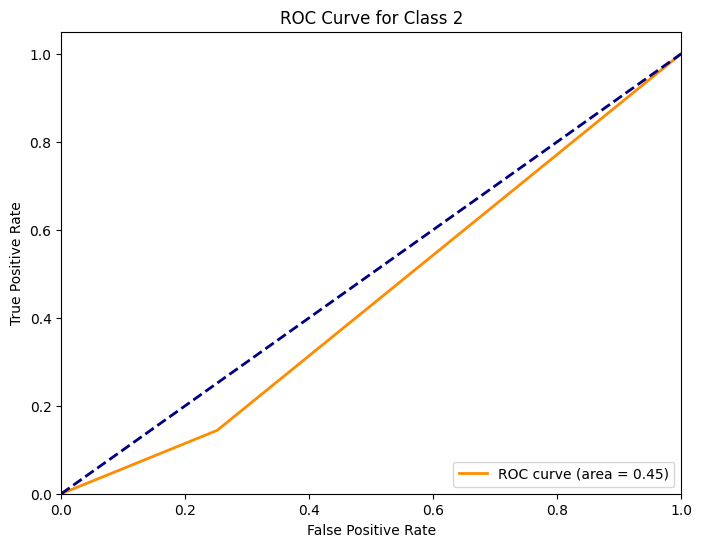

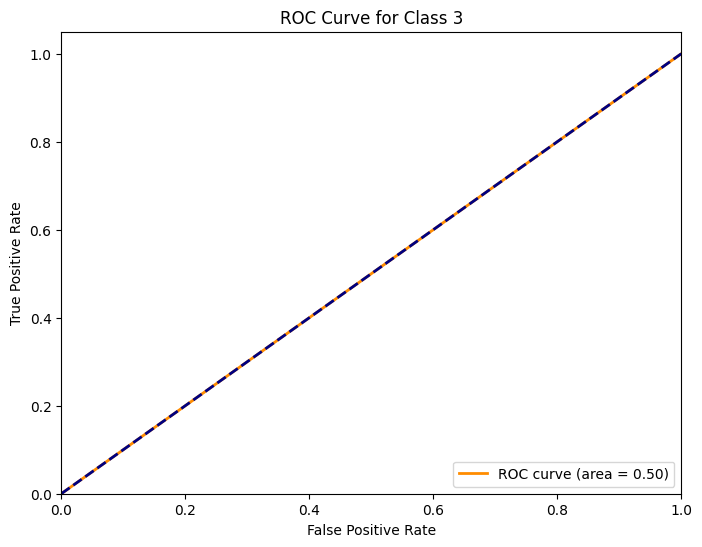

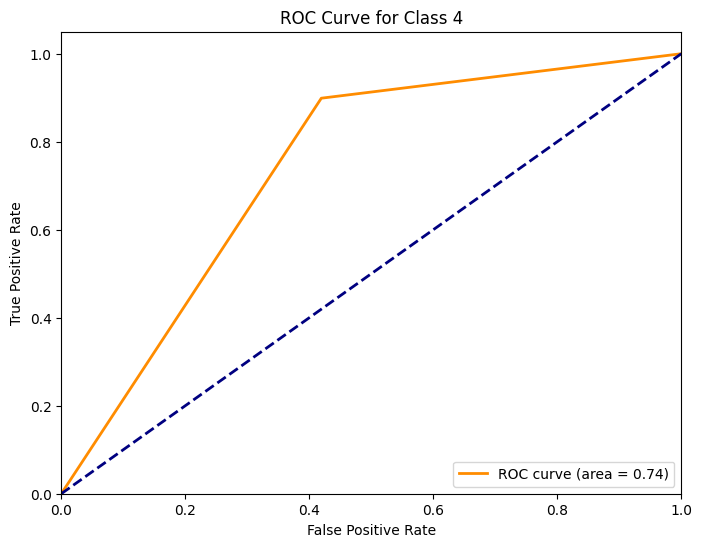

In [ ]:
# prompt: roc score for each class and plot them as graph separately

# Assuming y_true_binarized and y_pred_binarized are already defined from the previous code

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
# Plot ROC curves for each class in separate graphs
for i in range(n_classes):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i+1}')  # Use class number for title
    plt.legend(loc="lower right")
    plt.show()

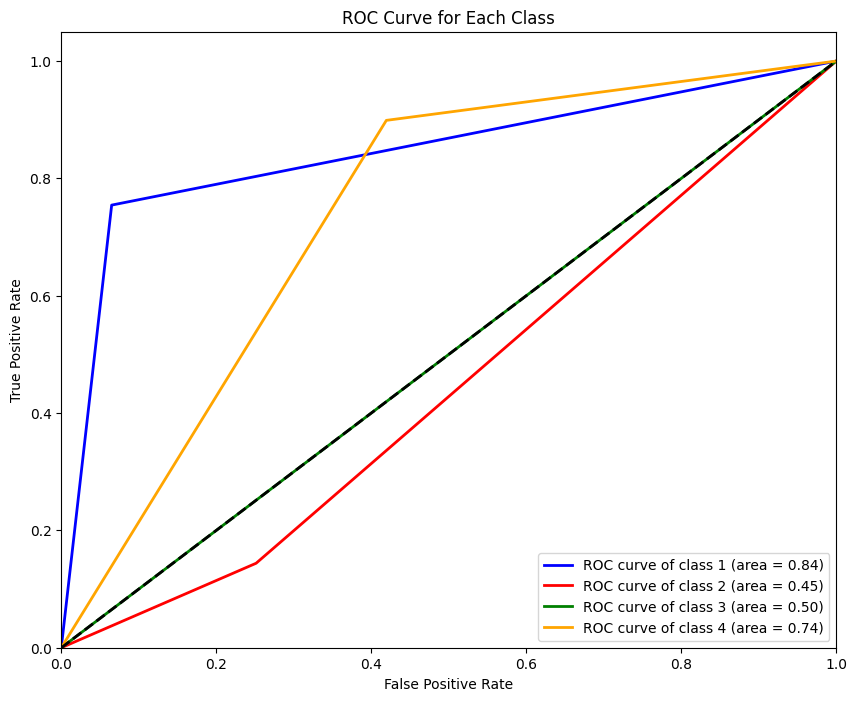

In [ ]:
# prompt: plot the roc curve for each class in one graph

# Assuming y_true_binarized and y_pred_binarized are already defined from the previous code

# Calculate ROC curve and AUC for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    # Fix: Use auc function from sklearn.metrics (or rename the previous roc_auc variable)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class in one graph
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if needed
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve of class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Overall ROC AUC (macro, ovo): 0.6326876000013903


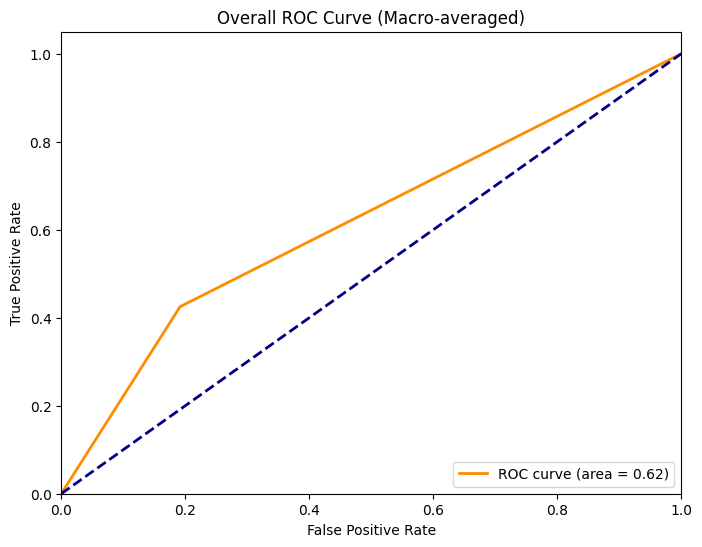

In [ ]:
# prompt: overall roc score and plot it as graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming y_true_numerical and y_pred are already defined from your previous code
# Example:
# y_true = df1['label']
# y_pred = df2['predicted_language']

# Convert to numerical labels if necessary

y_true_binarized = label_binarize(y_true_numerical, classes=[1, 2, 3, 4])
y_pred_binarized = label_binarize(y_pred, classes=[1, 2, 3, 4])

# Calculate overall ROC AUC (macro, ovo)
overall_roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro', multi_class='ovo')
print(f"Overall ROC AUC (macro, ovo): {overall_roc_auc}")

# Plot the overall ROC curve (macro-averaged)
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred_binarized.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve (Macro-averaged)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# prompt: overall f1 score,precision,recall

from sklearn.metrics import classification_report

report = classification_report(tl_label, pl_label, output_dict=True)

overall_f1 = report['macro avg']['f1-score']
overall_precision = report['macro avg']['precision']
overall_recall = report['macro avg']['recall']

print(f"Overall F1 Score: {overall_f1}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")

Overall F1 Score: 0.38698539961109263
Overall Precision: 0.37313067364059604
Overall Recall: 0.5158855052532056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


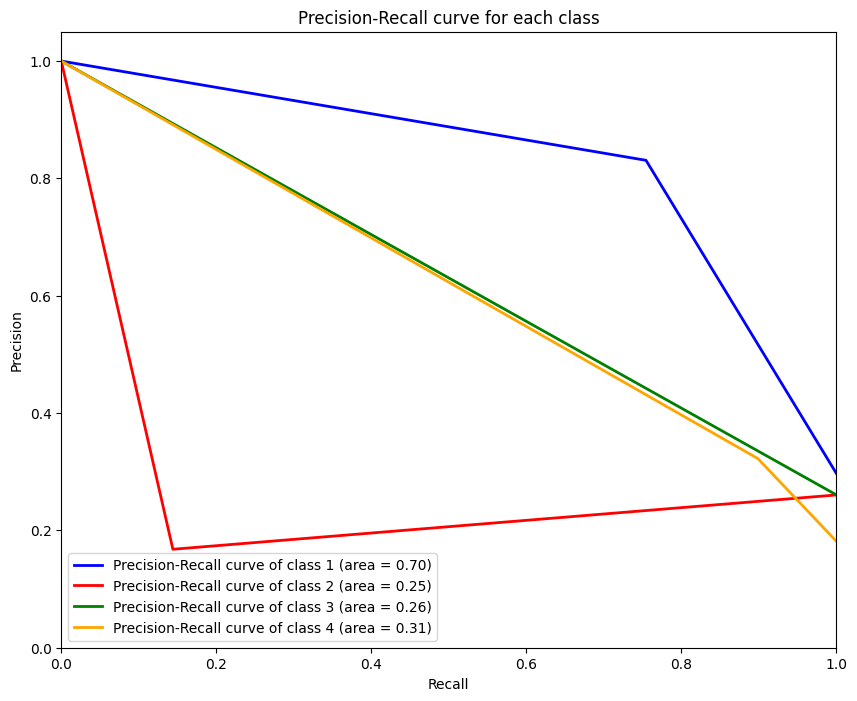

In [ ]:
# prompt: plot the Precision-Recall Curve (PRC)

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_true_binarized and y_pred_binarized are already defined
# from your previous code.  They should be one-hot encoded.

n_classes = y_true_binarized.shape[1]

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i],
                                                        y_pred_binarized[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_binarized[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2,
             label=f'Precision-Recall curve of class {i+1} (area = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="lower left")
plt.show()